# algorithms for massive data - market-basket analysis on amazon books reviews

## libraries import

In [1]:
import os
import zipfile
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, udf, array_contains, explode, row_number
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, NGram
from pyspark.ml.fpm import FPGrowth
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# NLTK downloads for lemmatization

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## general parameters

In [3]:
SAMPLE_SIZE = 0.01 # dataset sample fraction
SEED = 42 # random seed
MIN_SUPPORT = 0.01 # minumum support threshold for frequent itemset
MIN_CONFIDENCE = 0.2 # minimum confidence threshold for association rules

In [4]:
# words to keep in the analysis and used for obtaining meaningful bigrams.
# basically here we have words that will be removed from the most frequent words
# that are going to be searched automatically and removed. also these words are usefull because
# a bigram will be considered into our final basket if and only if one of the 2 words
# in the bigram is contained into this list.

KEEP_WORDS = {"good", "great", "excellent", "amazing", "wonderful", "brilliant", "fantastic",
              "bad", "terrible", "awful", "disappointing", "boring", "dull", "most",
              "love", "like", "hate", "best", "worst", "favorite", "recommended",
              "well", "interesting", "better", "easy", "recommend", "must", "high",
              "highly","very", "really", "quite", "much", "many", "lot", "enjoy", "prefer",
}

In [5]:
# words to be removed. include common stopwors and terms that could lead to insignificant
# words associations like 'higly' comporting 'recommended'.
# this list is a second iteration after the automatic stopwords removal based on frequency

BAN_TOKENS = {
    "take", "point", "last", "school", "young", "year", "get", "even", "something",
    "way", "make", "all", "just", "being", "over", "both", "through", "yourselves", "its",
    "before", "herself", "had", "should", "to", "only", "under", "ours", "has", "tell",
    "do", "them", "his", "they", "not", "during", "now", "him", "nor", "writing", "seem",
    "did", "this", "she", "each", "further", "where", "few", "because", "doing", "become",
    "some", "are", "our", "ourselves", "out", "what", "for", "while", "does", "look",
    "above", "between", "t", "be", "we", "who", "were", "here", "hers", "by", "use",
    "on", "about", "of", "against", "s", "or", "own", "into", "yourself", "down", "try",
    "your", "from", "her", "their", "there", "been", "whom", "too", "themselves",
    "was", "until", "more", "himself", "that", "but", "don", "with", "written", "leave",
    "those", "he", "me", "myself", "these", "will", "below", "can", "going", "may",
    "theirs", "my", "and", "then", "is", "am", "it", "an", "as", "itself", "at", "keep",
    "have", "in", "any", "if", "again", "no", "when", "how", "other", "also", "go",
    "which", "you", "after", "such", "why", "a", "off", "i", "yours", "always",
    "so", "the", "having", "once", "ago", "know", "want", "think", "find", "thing",
    "ever", "two", "end", "call", "first", "page", "found", "than", "another",
    "work", "see", "give", "every", "come", "say", "put", "still", "would",
    "day", "back", "made", "though", "however", "read", "later", "one", "need"
}

## data imports

In [6]:
os.environ['KAGGLE_USERNAME'] = "antdepa"
os.environ['KAGGLE_KEY'] = "bb4586df4d1661596f68edd3d214b0c0"

In [7]:
zip_path = "./data/amazon-books-reviews.zip"
csv_path = "./data/Books_rating.csv"

In [8]:
# dataset download if not preset

if not os.path.exists(zip_path) and not os.path.exists(csv_path):
    os.system("kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p ./data")

In [9]:
# extraction of the csv format dataset from the zip file if needed

if not os.path.exists(csv_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        for file in z.namelist():
            if "Books_rating.csv" in file:
                z.extract(file, "./data")
                os.rename(f"./data/{file}", csv_path)

## spark session initialization

In [10]:
spark = SparkSession.builder.appName("Frequent_items") \
    .master("local[*]") \
    .getOrCreate()

In [11]:
# sampled dataset

books = spark.read.csv(csv_path, header=True, inferSchema=True).sample(SAMPLE_SIZE,SEED)

In [12]:
books.show(10)

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|0312322291|King James: Belie...| NULL|          NULL|                NULL|               2/2|         5.0| 1118188800|Yo Homie this is ...|"LeBron James is ...|
|B0006D6DRK|Open marriage;: A...| NULL|A3KBF2S2MGN48O|"T. Thompson ""&#...|               2/2|         4.0| 1188604800|A Must Read for a...|This book is a cl...|
|0671551345|Night World: Daug...| NULL|          NULL|                NULL|               0/0|         5.0|  889920000|The most charming...|The plot and char...|
|B0008852GG|The soul of man 

In [13]:
books.count()

30332

## null values handling

In [14]:
# keep only reviews where the content is not null and not just empty whitespace

books_clean = books.filter(
    (~col('review/text').isNull()) &  # condition: 'review/text' must NOT be null
    (~col('review/text').rlike(r'^\s*$'))  # condition: 'review/text' must NOT be empty or only whitespace
)

In [15]:
books_clean.show(10)

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|0312322291|King James: Belie...| NULL|          NULL|                NULL|               2/2|         5.0| 1118188800|Yo Homie this is ...|"LeBron James is ...|
|B0006D6DRK|Open marriage;: A...| NULL|A3KBF2S2MGN48O|"T. Thompson ""&#...|               2/2|         4.0| 1188604800|A Must Read for a...|This book is a cl...|
|0671551345|Night World: Daug...| NULL|          NULL|                NULL|               0/0|         5.0|  889920000|The most charming...|The plot and char...|
|B0008852GG|The soul of man 

## tokenization

In [16]:
# tokenization of the text by non-word characters and later convert it to lowercase

tokenizer = RegexTokenizer(
    inputCol="review/text",
    outputCol="tokens",
    pattern=r"\W+", # split on non-word characters
    toLowercase=True
)

In [17]:
tokenized = tokenizer.transform(books_clean)

## lemmatization

In [18]:
lemmatizer = WordNetLemmatizer()

In [19]:
def lemmatize_tokens(tokens):
    if not tokens:
        return []
    return [lemmatizer.lemmatize(t) for t in tokens]

In [20]:
lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))

In [21]:
tokens_lemmatized = tokenized.withColumn("tokens_lem", lemmatize_udf(col("tokens")))

## stopwords

In [22]:
stopwords_remover = StopWordsRemover(
    inputCol="tokens_lem",
    outputCol="tokens_nostopwords"
)

In [23]:
no_stopwords = stopwords_remover.transform(tokens_lemmatized)

## frequent words to be removed

In [24]:
def get_top_frequent_words(spark_df, col_name="tokens_nostopwords", top_n=20):
    freqs = (spark_df
             .select(explode(col(col_name)).alias("token"))
             .groupBy("token")
             .count()
             .orderBy(col("count").desc())
             .limit(top_n))
    return [row['token'] for row in freqs.collect()]

In [25]:
auto_stopwords = set(get_top_frequent_words(no_stopwords, "tokens_nostopwords", top_n=50))

In [26]:
print("Stopwords filtered:", sorted(list(auto_stopwords)))

Stopwords filtered: ['also', 'author', 'best', 'book', 'character', 'doe', 'even', 'find', 'first', 'found', 'get', 'go', 'good', 'great', 'ha', 'know', 'life', 'like', 'little', 'love', 'm', 'make', 'many', 'much', 'never', 'new', 'novel', 'one', 'page', 'people', 'quot', 'read', 'reader', 'reading', 'really', 'see', 'story', 'take', 'thing', 'think', 'time', 'two', 'wa', 'want', 'way', 'well', 'work', 'world', 'written', 'year']


In [27]:
auto_stopwords = auto_stopwords - KEEP_WORDS # remove words that are explicitly KEEP_WORDS

In [28]:
print("Stopwords filtered:", sorted(list(auto_stopwords)))

Stopwords filtered: ['also', 'author', 'book', 'character', 'doe', 'even', 'find', 'first', 'found', 'get', 'go', 'ha', 'know', 'life', 'little', 'm', 'make', 'never', 'new', 'novel', 'one', 'page', 'people', 'quot', 'read', 'reader', 'reading', 'see', 'story', 'take', 'thing', 'think', 'time', 'two', 'wa', 'want', 'way', 'work', 'world', 'written', 'year']


In [29]:
auto_stopwords = auto_stopwords - {"author", "character", "novel", "story"}

In [30]:
def filter_tokens(tokens):
    if not tokens:
        return [] # return [] if input is empty

    words_to_remove = (auto_stopwords | BAN_TOKENS) - KEEP_WORDS

    # keep tokens that are:
    # - not in words_to_remove
    # - longer than 2 chars
    # - not purely digits
    return [t for t in tokens
            if t not in words_to_remove
            and len(t) > 2
            and not t.isdigit()]


In [31]:
filter_udf = udf(filter_tokens, ArrayType(StringType()))

In [32]:
tokens_filtered = no_stopwords.withColumn("tokens_filtered", filter_udf(col("tokens_nostopwords")))

## bigrams

In [33]:
bigram = NGram(n=2, inputCol="tokens_filtered", outputCol="bigrams_raw")

In [34]:
with_bigrams = bigram.transform(tokens_filtered)

In [35]:
# return only bigrams that start with a negative word, joined by '_'

def filter_neg_bigrams(bigrams):
    if not bigrams or not isinstance(bigrams, list):
        return []

    NEGATIVE_STARTERS = {"didnt", "dont", "never", "cannot", "no", "not", "wont", "isnt", "wasnt", "couldnt", "shouldnt"}
    result = []

    for bg in bigrams:
        w1, w2 = bg.split()
        if w1 in NEGATIVE_STARTERS:
            result.append(f"{w1}_{w2}")

    return result

In [36]:
filter_didnt_bigrams_udf = udf(filter_neg_bigrams, ArrayType(StringType()))

In [37]:
with_bigrams = with_bigrams.withColumn("meaningful_bigrams", filter_didnt_bigrams_udf(col("bigrams_raw")))

## tokens and bigrams combination

In [38]:
def combine_tokens_bigrams(tokens, bigrams):
    tokens = tokens or []
    bigrams = bigrams or []
    return list(dict.fromkeys(tokens + bigrams))

In [39]:
combine_udf = udf(combine_tokens_bigrams, ArrayType(StringType()))

In [40]:
combined = with_bigrams.withColumn("basket", combine_udf(col("tokens_filtered"), col("meaningful_bigrams")))

## sample baskets

In [41]:
combined.show(20, truncate=True)

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|              tokens|          tokens_lem|  tokens_nostopwords|     tokens_filtered|         bigrams_raw|meaningful_bigrams|              basket|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|0312322291|King James: Belie...| NULL|          NULL|                NULL|    

In [42]:
sample_baskets = combined.take(100)
all_items = []
for basket in sample_baskets:
    all_items.extend(basket['basket'])

bigram_items = [item for item in all_items if '_' in item]
single_items = [item for item in all_items if '_' not in item]

print(f"Bigrams found: {len(set(bigram_items))}")
print(f"Single token: {len(set(single_items))}")
print(f"Bigram examples: {sorted(set(bigram_items))[:5]}")

Bigrams found: 3
Single token: 2201
Bigram examples: ['didnt_anything', 'didnt_like', 'didnt_mind']


## FPGrowth model for frequent itemsets

In [43]:
fpGrowth = FPGrowth(itemsCol="basket", minSupport=MIN_SUPPORT, minConfidence=MIN_CONFIDENCE)

In [44]:
model = fpGrowth.fit(combined)

In [45]:
# display frequent itemsets, association rules, and predictions

print("Frequent Itemsets:")
model.freqItemsets.orderBy("freq", ascending=False).show(truncate=False)

print("Association Rules:")
model.associationRules.orderBy("confidence", ascending=False).show(truncate=False)

print("Predictions:")
predictions = model.transform(combined)
predictions.orderBy("prediction", ascending=False).show(5, truncate=False)

Frequent Itemsets:
+------------------+----+
|items             |freq|
+------------------+----+
|[story]           |7427|
|[like]            |6726|
|[good]            |5690|
|[great]           |5685|
|[character]       |5239|
|[well]            |5168|
|[many]            |4648|
|[much]            |4492|
|[love]            |4276|
|[really]          |4117|
|[author]          |3886|
|[novel]           |3815|
|[best]            |3220|
|[recommend]       |2783|
|[thought]         |2553|
|[interesting]     |2413|
|[character, story]|2385|
|[better]          |2373|
|[must]            |2311|
|[lot]             |2258|
+------------------+----+
only showing top 20 rows

Association Rules:
+------------------------+-----------+------------------+------------------+--------------------+
|antecedent              |consequent |confidence        |lift              |support             |
+------------------------+-----------+------------------+------------------+--------------------+
|[main, novel]    

In [46]:
model.associationRules.filter((col("lift") > 1.2) & (col("confidence") > 0.3)).show(truncate=False) # filtering rules with strong lift and confidence

+-------------+-----------+-------------------+------------------+--------------------+
|antecedent   |consequent |confidence         |lift              |support             |
+-------------+-----------+-------------------+------------------+--------------------+
|[amazing]    |[story]    |0.3515881708652793 |1.4358449993960936|0.01058323167716198 |
|[past]       |[like]     |0.33189655172413796|1.4966925825668789|0.010154627279021463|
|[past]       |[story]    |0.41810344827586204|1.7074856186421397|0.012792192806040025|
|[place, like]|[story]    |0.521669341894061  |2.130436624342098 |0.010715109953512908|
|[man]        |[character]|0.3056066176470588 |1.7692984004300327|0.021924763443341797|
|[man]        |[like]     |0.35202205882352944|1.5874488650277239|0.02525468992120273 |
|[man]        |[story]    |0.42922794117647056|1.7529167475189886|0.03079357752794171 |
|[great, good]|[like]     |0.3870192307692308 |1.745269147853336 |0.015924301869374567|
|[great, good]|[story]    |0.376

In [47]:
windowSpec = Window.orderBy(col("confidence").desc())

In [48]:
rules_with_index = model.associationRules.withColumn("row_num", row_number().over(windowSpec))

In [49]:
rules_with_index.filter(col("row_num") > 20).show(truncate=False)

+--------------------------+-----------+------------------+------------------+--------------------+-------+
|antecedent                |consequent |confidence        |lift              |support             |row_num|
+--------------------------+-----------+------------------+------------------+--------------------+-------+
|[well, character]         |[story]    |0.55863539445629  |2.2814016627512763|0.02591408130295737 |21     |
|[much, character, like]   |[story]    |0.5586206896551724|2.2813416100620754|0.010682140384425175|22     |
|[man, novel]              |[story]    |0.5545774647887324|2.2648295522427686|0.010385414262635588|23     |
|[feel, character]         |[story]    |0.5543018335684062|2.2637039065522186|0.012957040651478685|24     |
|[novel, character, like]  |[story]    |0.5538694992412747|2.2619383036875056|0.012033892717022189|25     |
|[novel, author]           |[character]|0.5494978479196556|3.1812978097444313|0.012627344960601364|26     |
|[novel, well]             |

In [50]:
rules_with_index.filter(col("row_num") > 40).show(truncate=False)

+------------------------+-----------+------------------+------------------+--------------------+-------+
|antecedent              |consequent |confidence        |lift              |support             |row_num|
+------------------------+-----------+------------------+------------------+--------------------+-------+
|[novel, like]           |[character]|0.5366449511400652|3.1068864311947544|0.021726946028815402|41     |
|[character, good]       |[story]    |0.5362210604929052|2.18986414242767  |0.023672150604991594|42     |
|[highly]                |[recommend]|0.5349127182044888|5.829837461681764 |0.028287890277274075|43     |
|[author, character]     |[story]    |0.5339412360688957|2.180553605925094 |0.017374962909234775|44     |
|[novel, many]           |[character]|0.530454042081949 |3.0710443883160137|0.01579242359302364 |45     |
|[character, great]      |[story]    |0.5272727272727272|2.1533201953560104|0.021034585077973032|46     |
|[novel, many]           |[story]    |0.526024

In [51]:
rules_with_index.filter(col("row_num") > 60).show(truncate=False)

+---------------------+-----------+-------------------+------------------+--------------------+-------+
|antecedent           |consequent |confidence         |lift              |support             |row_num|
+---------------------+-----------+-------------------+------------------+--------------------+-------+
|[novel, great]       |[story]    |0.5120274914089347 |2.09106043381236  |0.014737397382216215|61     |
|[much, like, story]  |[character]|0.5118483412322274 |2.9633273597852057|0.010682140384425175|62     |
|[really, character]  |[like]     |0.5099457504520796 |2.2996081708239706|0.018594836965480862|63     |
|[novel, great]       |[character]|0.5097365406643757 |2.951101167186711 |0.014671458244040751|64     |
|[novel, character]   |[story]    |0.5092137592137592 |2.0795694803706115|0.027331772773729848|65     |
|[well, like, story]  |[character]|0.5088282504012841 |2.945842653735703 |0.010451353400811051|66     |
|[plot, novel]        |[story]    |0.5078864353312302 |2.0741488

## visualizations

In [52]:
freq_itemsets = model.freqItemsets.toPandas()
assoc_rules = model.associationRules.toPandas()

In [53]:
top_items = freq_itemsets.sort_values(by="freq", ascending=False).head(20) # top 20 frequent itemsets
top_items['items_str'] = top_items['items'].apply(lambda x: ', '.join(x))

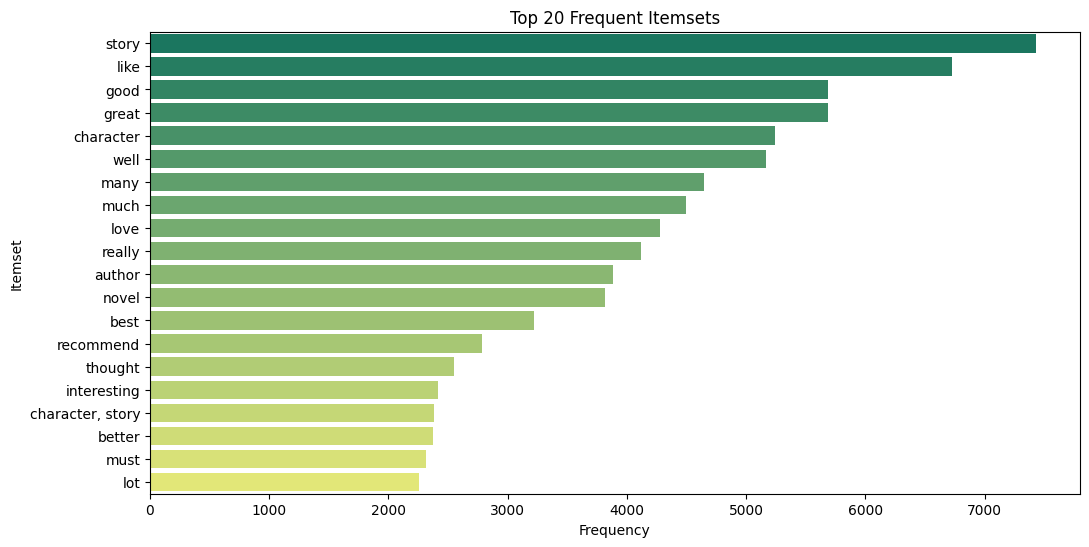

In [54]:
plt.figure(figsize=(12,6))
sns.barplot(x="freq", y="items_str", data=top_items, palette="summer")
plt.title("Top 20 Frequent Itemsets")
plt.xlabel("Frequency")
plt.ylabel("Itemset")
plt.show()

In [55]:
top_rules = assoc_rules.sort_values(by="confidence", ascending=False).head(20) # top 20 association rules
top_rules['rule_str'] = top_rules['antecedent'].apply(lambda x: ', '.join(x)) + " -> " + top_rules['consequent'].apply(lambda x: ', '.join(x))

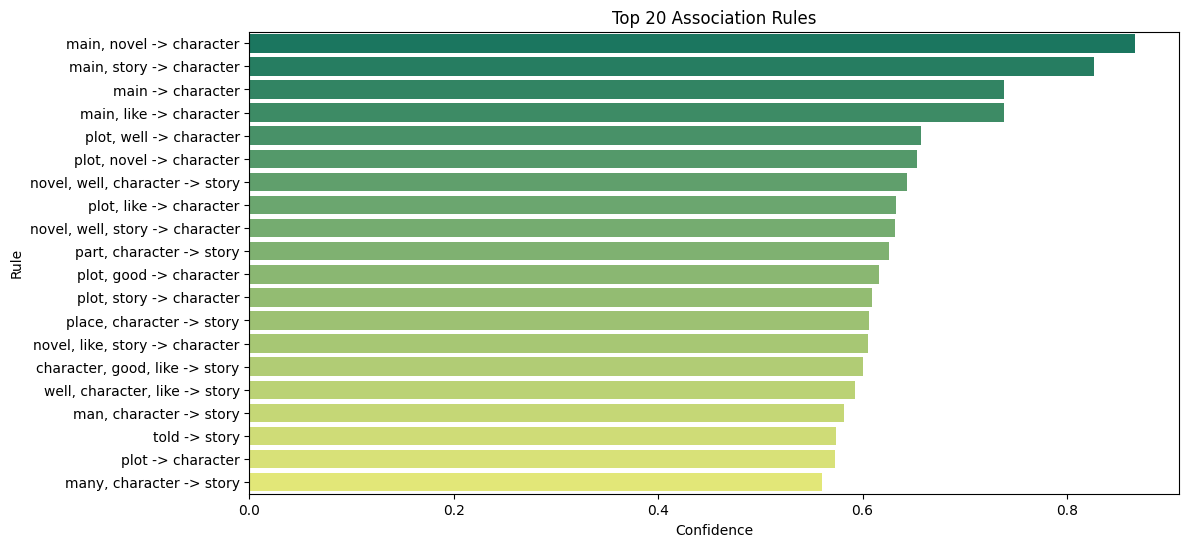

In [56]:
plt.figure(figsize=(12,6))
sns.barplot(x="confidence", y="rule_str", data=top_rules, palette="summer")
plt.title("Top 20 Association Rules")
plt.xlabel("Confidence")
plt.ylabel("Rule")
plt.show()

## parameter sensitivity analysis

In [57]:
# performs a grid search over different minSupport and minConfidence values

def parameter_sensitivity_analysis(combined_df):
    support_values = [0.005, 0.01, 0.02]
    confidence_values = [0.1, 0.2, 0.3]
    results = []

    for support in support_values:
        for confidence in confidence_values:
            print(f"\nTesting: Support={support}, Confidence={confidence}")
            start = time.time()

            # fit the model with the given support and confidence
            model = FPGrowth(itemsCol="basket", minSupport=support, minConfidence=confidence).fit(combined_df)

            # count frequent itemsets and association rules
            num_itemsets = model.freqItemsets.count()
            num_rules = model.associationRules.count()

            # measure time
            final_time = time.time() - start

            results.append({
                "support": support,
                "confidence": confidence,
                "num_itemsets": num_itemsets,
                "num_rules": num_rules,
                "training_time": final_time
            })

            print(f"Itemsets: {num_itemsets:,}")
            print(f"Rules: {num_rules:,}")
            print(f"Time: {final_time:.2f}s")

    return pd.DataFrame(results)

In [58]:
param_results = parameter_sensitivity_analysis(combined)
print("\n-------------------summary table-------------------")
print(param_results.to_string(index=False))


Testing: Support=0.005, Confidence=0.1
Itemsets: 8,337
Rules: 10,833
Time: 1295.42s

Testing: Support=0.005, Confidence=0.2
Itemsets: 8,337
Rules: 7,750
Time: 1284.34s

Testing: Support=0.005, Confidence=0.3
Itemsets: 8,337
Rules: 4,584
Time: 1303.43s

Testing: Support=0.01, Confidence=0.1
Itemsets: 1,971
Rules: 1,849
Time: 926.98s

Testing: Support=0.01, Confidence=0.2
Itemsets: 1,971
Rules: 1,506
Time: 915.76s

Testing: Support=0.01, Confidence=0.3
Itemsets: 1,971
Rules: 712
Time: 904.97s

Testing: Support=0.02, Confidence=0.1
Itemsets: 461
Rules: 296
Time: 575.40s

Testing: Support=0.02, Confidence=0.2
Itemsets: 461
Rules: 202
Time: 589.28s

Testing: Support=0.02, Confidence=0.3
Itemsets: 461
Rules: 100
Time: 594.43s

-------------------summary table-------------------
 support  confidence  num_itemsets  num_rules  training_time
   0.005         0.1          8337      10833    1295.419991
   0.005         0.2          8337       7750    1284.340133
   0.005         0.3          833

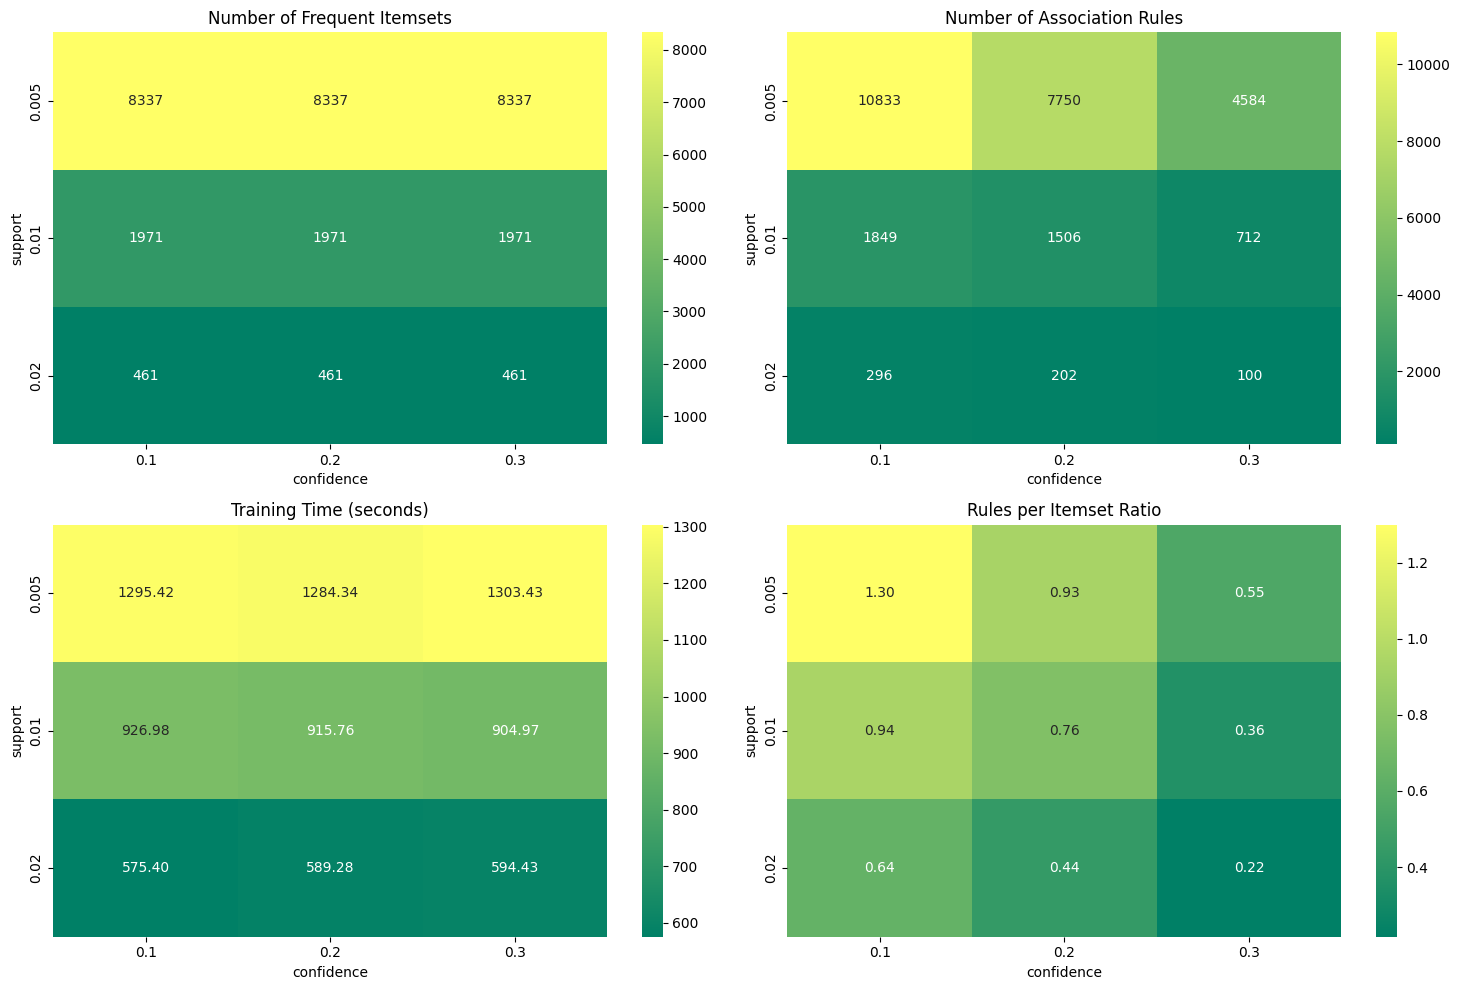

In [59]:
# heatmaps for sensitivity analysis

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# heatmap 1: number of frequent itemsets for each support-confidence combination
pivot_itemsets = param_results.pivot(index='support', columns='confidence', values='num_itemsets')
sns.heatmap(pivot_itemsets, annot=True, fmt='d', ax=axes[0,0], cmap='summer')
axes[0,0].set_title('Number of Frequent Itemsets')

# heatmap 2: number of association rules for each support-confidence combination
pivot_rules = param_results.pivot(index='support', columns='confidence', values='num_rules')
sns.heatmap(pivot_rules, annot=True, fmt='d', ax=axes[0,1], cmap='summer')
axes[0,1].set_title('Number of Association Rules')

# heatmap 3: training time in seconds for each parameter combination
pivot_time = param_results.pivot(index='support', columns='confidence', values='training_time')
sns.heatmap(pivot_time, annot=True, fmt='.2f', ax=axes[1,0], cmap='summer')
axes[1,0].set_title('Training Time (seconds)')

# heatmap 4: ratio of rules per itemset for each combination
param_results['rules_per_itemset'] = param_results['num_rules'] / param_results['num_itemsets']
pivot_ratio = param_results.pivot(index='support', columns='confidence', values='rules_per_itemset')
sns.heatmap(pivot_ratio, annot=True, fmt='.2f', ax=axes[1,1], cmap='summer')
axes[1,1].set_title('Rules per Itemset Ratio')

plt.tight_layout()
plt.show()